# Modelo de sobremuestreo

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import os
from os import listdir
from os.path import isfile, join

## <font color=red>1. </font>Cargar las imágenes y los datos tabulares

In [2]:
# Resized images directory
dir_2019_images = "/kaggle/input/resizedsiimisic/train_resized/"

# CSV file
train_df = pd.read_csv('/kaggle/input/resizedsiimisic/train.csv')

In [3]:
train_df.head()

,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0000000.jpg,female,55.0,anterior torso,0.0
1,ISIC_0000001.jpg,female,30.0,anterior torso,0.0
2,ISIC_0000002.jpg,female,60.0,upper extremity,1.0
3,ISIC_0000003.jpg,male,30.0,upper extremity,0.0
4,ISIC_0000004.jpg,male,80.0,posterior torso,1.0


In [4]:
print("Train shape:", train_df.shape)

Train shape: (22480, 5)


## <font color=red>2. </font>Sobremuestreo de las imágenes minoritarias

In [5]:
train_df.target.value_counts().rename_axis('Tipo').reset_index(name='Total de muestras')

,Tipo,Total de muestras
0,0.0,18134
1,1.0,4346


In [6]:
from collections import Counter
from sklearn.model_selection import train_test_split

X = train_df
y = train_df['target']

In [7]:
# Split into train, validation test and calibration sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=42)

X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, 
                                                    test_size=0.4,
                                                    stratify=y_test,
                                                    random_state=42)


print("Conjunto de train:", X_train.shape)
print("Conjunto de validacion:", X_val.shape)
print("Conjunto de prueba:", X_test.shape)
print("Conjunto de calibracion:", X_calib.shape)
print("-----------------------")
print('Distribucion de train ->', Counter(y_train))
print('Distribucion de validacion ->', Counter(y_val))
print("Distribucion de prueba:", Counter(y_test))
print("Distribucion de calibracion:", Counter(y_calib))

Conjunto de train: (14387, 5)
Conjunto de validacion: (3597, 5)
Conjunto de prueba: (2697, 5)
Conjunto de calibracion: (1799, 5)
-----------------------
Distribucion de train -> Counter({0.0: 11605, 1.0: 2782})
Distribucion de validacion -> Counter({0.0: 2902, 1.0: 695})
Distribucion de prueba: Counter({0.0: 2176, 1.0: 521})
Distribucion de calibracion: Counter({0.0: 1451, 1.0: 348})


In [8]:
benign = X_train.loc[X_train['target'] == 0]
benign.head()

,image_name,sex,age_approx,anatom_site_general_challenge,target
15122,ISIC_0061325.jpg,male,45.0,anterior torso,0.0
6834,ISIC_0030164.jpg,female,45.0,upper extremity,0.0
21536,ISIC_0071759.jpg,male,70.0,anterior torso,0.0
2085,ISIC_0024446.jpg,male,45.0,upper extremity,0.0
3999,ISIC_0026784.jpg,male,30.0,posterior torso,0.0


In [9]:
from PIL import Image 

def save_images_jpg(dir_original_images, df, file):
    dir_images = '/kaggle/working/' + file + "/" 
    try:
        os.mkdir('/kaggle/working/' + file)
        print("Directory", file, "created") 
    except FileExistsError:
        print("Directory", file, "already exists")
        
    print("Saving images...")
    total_images = len(df['image_name'])
    total_images_saved = 0
    
    for image in df['image_name'].values:
        img = Image.open(dir_original_images + image)
        img.save(dir_images + image)
        total_images_saved += 1
        percentage_saved = (total_images_saved / total_images) * 100
        # Every 1000 images saved, print progress
        if total_images_saved % 1000 == 0:
            print("Images saved", percentage_saved, "%")
    print("Images saved")
    
    return df

In [10]:
benign = save_images_jpg(dir_2019_images, benign, "train_resized")

Directory train_resized created
Saving images...
Images saved 8.61697544161999 %
Images saved 17.23395088323998 %
Images saved 25.850926324859973 %
Images saved 34.46790176647996 %
Images saved 43.08487720809996 %
Images saved 51.701852649719946 %
Images saved 60.31882809133994 %
Images saved 68.93580353295992 %
Images saved 77.55277897457992 %
Images saved 86.16975441619992 %
Images saved 94.7867298578199 %
Images saved


In [11]:
malignant = X_train.loc[X_train['target'] == 1]
malignant.head()

,image_name,sex,age_approx,anatom_site_general_challenge,target
1458,ISIC_0014099_downsampled.jpg,female,85.0,lower extremity,1.0
3458,ISIC_0026120.jpg,male,55.0,posterior torso,1.0
10324,ISIC_0053503.jpg,female,50.0,lower extremity,1.0
9319,ISIC_0033125.jpg,male,70.0,upper extremity,1.0
22248,ISIC_0072889.jpg,male,80.0,upper extremity,1.0


In [12]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dir_images = '/kaggle/working/train_resized/'
total_images = len(malignant['image_name'])*4
total_images_saved = 0

for image in malignant['image_name'].values:
    # Load the image and convert to numpy array
    img = load_img(dir_2019_images + image)
    data = img_to_array(img)
    samples = expand_dims(data, 0)
    
    # Get row
    df_row = malignant[malignant['image_name'] == image]
    # Delete old row
    malignant = malignant.drop(malignant.loc[malignant['image_name'] == image].index)
    
    # Create image data augmentation generator
    datagen = ImageDataGenerator(horizontal_flip=True, 
                                 vertical_flip=True, 
                                 rotation_range=90)
    # Prepare iterator
    it = datagen.flow(samples, batch_size=1)
    
    # Generate samples and save augmented images
    for i in range(4):
        batch = it.next()
        image_aug = batch[0].astype('uint8')
        
        # Change image_name_i
        image_ = image[:len(image) - 4] + '_' + str(i) + ".jpg"
        df_row['image_name'] = image_
        # Append to dataframe
        malignant = malignant.append(df_row)
                
        # Save augmented image
        im = Image.fromarray(image_aug)
        filename = str(dir_images + image_)
        im.save(filename)
        
        # Every 1000 images saved, print progress
        total_images_saved += 1
        percentage_saved = (total_images_saved / total_images) * 100
        if total_images_saved % 1000 == 0:
            print("Images saved", percentage_saved, "%")

print("Images saved")

Images saved 8.986340762041696 %
Images saved 17.97268152408339 %
Images saved 26.95902228612509 %
Images saved 35.94536304816678 %
Images saved 44.93170381020848 %
Images saved 53.91804457225018 %
Images saved 62.90438533429188 %
Images saved 71.89072609633357 %
Images saved 80.87706685837527 %
Images saved 89.86340762041696 %
Images saved 98.84974838245866 %
Images saved


In [13]:
import shutil

shutil.make_archive('train_resized', 'zip', '/kaggle/working/train_resized')

'/kaggle/working/train_resized.zip'

In [14]:
malignant.head(10)

,image_name,sex,age_approx,anatom_site_general_challenge,target
1458,ISIC_0014099_downsampled_0.jpg,female,85.0,lower extremity,1.0
1458,ISIC_0014099_downsampled_1.jpg,female,85.0,lower extremity,1.0
1458,ISIC_0014099_downsampled_2.jpg,female,85.0,lower extremity,1.0
1458,ISIC_0014099_downsampled_3.jpg,female,85.0,lower extremity,1.0
3458,ISIC_0026120_0.jpg,male,55.0,posterior torso,1.0
3458,ISIC_0026120_1.jpg,male,55.0,posterior torso,1.0
3458,ISIC_0026120_2.jpg,male,55.0,posterior torso,1.0
3458,ISIC_0026120_3.jpg,male,55.0,posterior torso,1.0
10324,ISIC_0053503_0.jpg,female,50.0,lower extremity,1.0
10324,ISIC_0053503_1.jpg,female,50.0,lower extremity,1.0


In [15]:
new_X_train = pd.concat([benign, malignant], ignore_index=False)
new_X_train = new_X_train.reset_index()

new_X_train.head()

,index,image_name,sex,age_approx,anatom_site_general_challenge,target
0,15122,ISIC_0061325.jpg,male,45.0,anterior torso,0.0
1,6834,ISIC_0030164.jpg,female,45.0,upper extremity,0.0
2,21536,ISIC_0071759.jpg,male,70.0,anterior torso,0.0
3,2085,ISIC_0024446.jpg,male,45.0,upper extremity,0.0
4,3999,ISIC_0026784.jpg,male,30.0,posterior torso,0.0


In [16]:
new_X_train.target.value_counts().rename_axis('Tipo').reset_index(name='Total de muestras')

,Tipo,Total de muestras
0,0.0,11605
1,1.0,11128


In [17]:
new_X_train.to_csv('/kaggle/working/train.csv', index=False)
X_val.to_csv('/kaggle/working/val.csv', index=False)
X_calib.to_csv('/kaggle/working/calib.csv', index=False)
X_test.to_csv('/kaggle/working/test.csv', index=False)

In [18]:
new_X_train["target"] = new_X_train['target'].astype(str)
X_val["target"] = X_val['target'].astype(str)
X_calib["target"] = X_calib['target'].astype(str)
X_test["target"] = X_test['target'].astype(str)

## <font color=red>3. </font>Crear y entrenar el modelo

In [19]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

In [22]:
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=new_X_train,
    directory=dir_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=X_val,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

calib_generator = datagen.flow_from_dataframe(
    dataframe=X_calib,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_CALIB = calib_generator.n//calib_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 22733 validated image filenames belonging to 2 classes.
Found 3597 validated image filenames belonging to 2 classes.
Found 1799 validated image filenames belonging to 2 classes.
Found 2697 validated image filenames belonging to 2 classes.


In [23]:
encoder = DenseNet121(input_shape=(None,None,3), 
                      include_top=False, 
                      weights='imagenet')

In [24]:
inputs = Input(shape=(None, None, 3))
x = encoder(inputs, training=False)
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model_oversampling = Model(inputs=inputs, outputs=predictions)

In [25]:
model_oversampling.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [26]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      AUC(name='auc')
]

In [27]:
checkpoint_filepath = '/kaggle/working/oversampling_model.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_auc',
                                            mode='max',
                                            verbose=1,
                                            save_best_only=True)

In [28]:
model_oversampling.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=METRICS
)

In [30]:
model_oversampling.fit(train_generator,  
                       validation_data =valid_generator,
                       steps_per_epoch=STEP_SIZE_TRAIN, 
                       validation_steps=STEP_SIZE_VALID,
                       callbacks=[model_checkpoint_callback],
                       epochs = 100)

Epoch 1/100
710/710 [==============================] - 218s 308ms/step - loss: 0.7102 - tp: 4600.0000 - fp: 4499.0000 - tn: 7090.0000 - fn: 6512.0000 - auc: 0.5178 - val_loss: 0.6571 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2890.0000 - val_fn: 694.0000 - val_auc: 0.5233

Epoch 00001: val_auc improved from -inf to 0.52326, saving model to /kaggle/working/oversampling_model.h5
Epoch 2/100
710/710 [==============================] - 203s 286ms/step - loss: 0.7023 - tp: 3754.0000 - fp: 3633.0000 - tn: 7953.0000 - fn: 7361.0000 - auc: 0.5169 - val_loss: 0.7225 - val_tp: 690.0000 - val_fp: 2894.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_auc: 0.5115

Epoch 00002: val_auc did not improve from 0.52326
Epoch 3/100
710/710 [==============================] - 204s 287ms/step - loss: 0.7293 - tp: 2811.0000 - fp: 2983.0000 - tn: 8605.0000 - fn: 8302.0000 - auc: 0.5004 - val_loss: 0.6784 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2891.0000 - val_fn: 693.0000 - val_auc: 0.5

## <font color=red>4. </font>Evaluar el modelo

In [31]:
eval_metrics = model_oversampling.evaluate(test_generator,
                                           steps=STEP_SIZE_TEST,
                                           return_dict=True,
                                           use_multiprocessing=False,
                                           verbose=1)

84/84 [==============================] - 18s 216ms/step - loss: 1.1614 - tp: 91.0000 - fp: 130.0000 - tn: 2038.0000 - fn: 429.0000 - auc: 0.6102


In [32]:
calib_labels = calib_generator.classes
test_labels = test_generator.classes

predict_calib = model_oversampling.predict(calib_generator,
                                           verbose=1)
predict_test = model_oversampling.predict(test_generator,
                                          verbose=1)

85/85 [==============================] - 7s 82ms/step


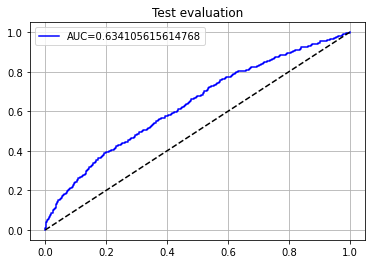

In [33]:
from sklearn import metrics

fpr, tpr, tr = metrics.roc_curve(test_labels, predict_test.ravel())
auc = metrics.roc_auc_score(test_labels, predict_test.ravel())
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation')
plt.grid()
plt.legend(loc='best')
plt.show()

#### Finalmente, se observa la matriz de confusión para el conjunto de prueba y calibración.

In [34]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(test_labels, np.where(np.array(predict_test.ravel()) > 0.5, 1, 0))
cm_test

array([[2046,  130],
       [ 430,   91]])

Test dataset


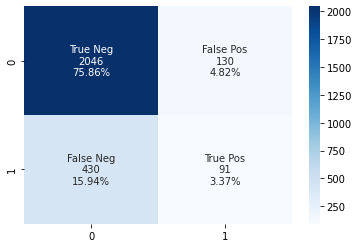

In [35]:
import seaborn as sns

cm = [cm_test[0][0], cm_test[0][1], cm_test[1][0], cm_test[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')
print("Test dataset")

In [36]:
cm_calib = confusion_matrix(calib_labels, np.where(np.array(predict_calib.ravel()) > 0.5, 1, 0))
cm_calib

array([[1368,   83],
       [ 282,   66]])

Calibration dataset


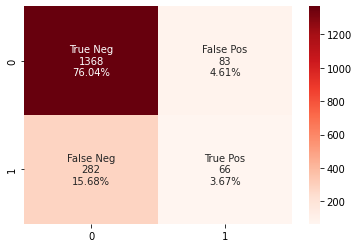

In [37]:
cm = [cm_calib[0][0], cm_calib[0][1], cm_calib[1][0], cm_calib[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Reds')
print("Calibration dataset")

In [43]:
over_test_predictions = {'Ground Truth': test_labels,
                         'Oversampling Classifier prediction': predict_test.ravel().astype(str)}

df_test_predictions = pd.DataFrame(over_test_predictions)
df_test_predictions.head()

,Ground Truth,Oversampling Classifier prediction
0,0,3.6826845e-05
1,0,7.300908e-05
2,0,2.2039054e-05
3,0,8.037302e-06
4,1,4.3131986e-06


In [44]:
over_calib_predictions = {'Ground Truth': calib_labels,
                          'Oversampling Classifier prediction': predict_calib.ravel().astype(str)}

df_calib_predictions = pd.DataFrame(over_calib_predictions)
df_calib_predictions.head(10)

,Ground Truth,Oversampling Classifier prediction
0,0,0.10408526
1,0,0.11002688
2,0,1.656308e-06
3,0,0.0492219
4,0,3.973684e-05
5,0,0.005841968
6,0,0.0018426917
7,0,0.006934782
8,0,4.278233e-09
9,1,0.73296064


In [45]:
df_calib_predictions.to_csv('/kaggle/working/over_calib_predictions.csv', index=False)
df_test_predictions.to_csv('/kaggle/working/over_test_predictions.csv', index=False)

In [46]:
def delete_images_jpg(file):
    try:
        os.system(f'rm -rf /kaggle/working/{file}')
        print(f'Directory {file} deleted')
    except:
        print("Could not delete directory")

delete_images_jpg("train_resized")

Directory train_resized deleted
